<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Notebook for <br>Multi-scale CyberGIS Analytics for Detecting Spatiotemporal Patterns of COVID-19</h1>
<p style="text-align:center;font-size:12px;">
$Fangzheng$ $Lyu^{1,2}$; $JeonYoung$ $Kang^{3}$; $Shaohua$ $Wang^{1,2}$; $Su Yeon$ $Han^{1,2}$; $Zhiyu$ $Li^{1,2}$; $Shaowen$ $Wang^{1,2}$
</p>
<p style="text-align:center;font-size:12px;">
$^{1}$$Department$ $of$ $Geography$ $and$ $Geographic$ $Information$ $Science$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{2}$$CyberGIS$ $Center$ $for$ $Advanced$ $Digital$ $and$ $Spatial$ $Studies$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{3}$$Department$ $of$ $Geography$ $Education$, $Kongju$ $National$ $University$, $Gongjusi$, $Chungcheongnamdo$, $South Korea$<br>

</p>

---
    
**Notebook Structure:**
- [Introduction](#introduction)
- [Dataset](#data)
- Codes
 - [data exploration](#exploration)
 - [data preprocessing](#preprocessing)
 - [Space time kernel density estimation](#stkde) 
 - [postprocessing & analysis](#postprocessing)
 - [Visualization](#vis)

<a id='introduction'></a>
## Introduction

The ongoing COVID-19 pandemic has put the world into an unprecedented situation causing massive impacts on people’s daily life and businesses. While there exist numerous geospatial data portals and resources for fighting against the COVID-19 crisis, a major challenge is that few of these are based on rigorous geospatial analysis and modeling as many simply report COVID-19 cases and summary statistics. To tackle this challenge, it requires detailed data on populations, health care services, and high-risk settings, along with decision support tools for geospatial analytics and place-based intervention. Dynamic and interactive mapping informed by rigorous geospatial analysis and modeling is urgently needed for understanding how COVID-19 spreads across a number of spatial and temporal scales in various population contexts and for supporting decision making to mitigate the spread and minimize negative impacts. However, such geospatial analysis and modeling are often computation- and data-intensive, and thus require integration with and enablement by cyberGIS—geospatial information science and systems (GIS) based on advanced cyberinfrastructure. Therefore, this study aims to develop a cutting-edge cyberGIS approach to answer the following two research questions: (1) where are spatiotemporal clusters of COVID-19 death cases in the United States? and (2) what is the correlation between COVID-19 death case clusters and related socioeconomic factors? To answer these questions, we conducted a space-time kernel density estimation (STKDE) to explore spatiotemporal intensities of COVID-19 deaths in the United States. The results from STKDE provide a multi-scale understanding of the COVID-19 severity by identifying a number of spatiotemporal clusters centered around urban areas. Furthermore, the additional spatial correlation analysis based on STKDE results shows that the clustering regions with higher death rates are related to certain population characteristics (e.g., racial and socioeconomic status), highlighting the impacts of health disparities.

<a id='data'></a>
## Dataset

COVID-19 related data are used in this nobebook

  - **data/county.txt:** US counties information and fip code from Natural Resources Conservation Service

  - **data/us-counties.txt:** County-level COVID-19 data collected from New York Times COVID-19 github repository on August 4th

  - **data/covid_death.txt:** COVID-19 death information after processing us-counties.txt

  - **data/stkdefinal.txt:** result from conducting space-timne kernel density estimation

  - **wolfram_mathmatica/Visualization.nb:** code for visulization of STKDE result via weolfram mathmatica

  - **img/above.png:** 3-D visulization, above view

  - **img/side.png:** 3-D visulization, side view

<a id='exploration'></a>
## Data Exploration

This section explore the county-level COVID-19 dataset collected from New York Times COVID-19 github repository and the county dataset.

Import libraries & Read dataset for data/county.txt. Form a dictionary for all the counties.

In [1]:
## import libraries needed
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
## create a dictionary
county_dict = {}
index = 0
with open('./data/county.txt') as fp:
    for cnt, line in enumerate(fp):
        line_data = line.split("\t")
        fips = line_data[2]
        ## get the longitude & latitude
        lat = float(line_data[12][1:-2])
        lon = float(line_data[13][3:-3])*-1
        county_dict[index]=(fips, lat, lon)
        index = index+1

Transform the geographic projection form 'epsg:4326' (longitude, latitude) to 'epsg:3857'.

In [2]:
## Create a geopandas dataframe for all the counties
county_dict_df = pd.DataFrame.from_dict(county_dict, orient='index', columns=['id', 'latitude', 'longitude'])
s = gpd.GeoSeries([Point(x,y) for x, y in zip(county_dict_df['longitude'], county_dict_df['latitude'])])
geo_df = gpd.GeoDataFrame(county_dict_df[['id']], geometry=s)
## transform the geographic projection form 'epsg:4326' to 'epsg:3857'.
geo_df.crs = {'init': 'epsg:4326'} 
geo_df = geo_df.to_crs({'init': 'epsg:3857'})

C:\Users\Owner\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Create a dictionary with counties' fips to its spatial location

In [3]:
## Create a dictionary
final_county_dict = {}
for index, row in geo_df.iterrows():
    curr_id = row["id"]
    x = row["geometry"].y
    y = row["geometry"].x
    final_county_dict[curr_id] = (x, y)

Read county-level COVID-19 data

In [4]:
df = pd.read_csv("./data/us-counties.csv")
df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
418164,2020-08-09,Sweetwater,Wyoming,56037.0,259,2
418165,2020-08-09,Teton,Wyoming,56039.0,374,1
418166,2020-08-09,Uinta,Wyoming,56041.0,278,1
418167,2020-08-09,Washakie,Wyoming,56043.0,76,5


Create a dictionary for death case and confirmed case for each day

In [5]:
case_dict = {}
death_dict = {}
## loop the dataframe
for i, row in enumerate(df.values):
    time = row[0]
    case = int(row[4])
    death = int(row[5])
    if time in case_dict.keys():
        case_dict[time]=case_dict[time]+case
    else:
        case_dict[time]=case
    if time in death_dict.keys():
        death_dict[time]=death_dict[time]+death
    else:
        death_dict[time]=death

Create a array for date

In [6]:
import datetime
date = 0
date_arr = []
def column(matrix, i):
    return [row[i] for row in matrix]
for i in range(0,len(column(case_dict.items(), 0))):
    date_arr.append(datetime.datetime.strptime(column(case_dict.items(), 0)[i], '%Y-%m-%d'))

Create a chart for COVID-19 Confirmed Cases & Death in US

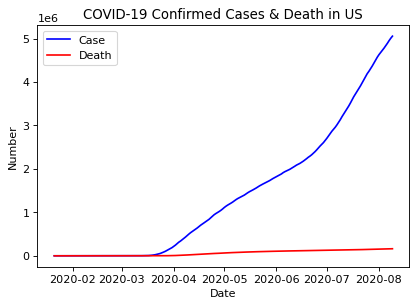

In [7]:
## import libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(figsize=(6, 4), dpi=80)
plt.plot(date_arr, column(case_dict.items(), 1), "-b", label="Case");
plt.plot(date_arr, column(death_dict.items(), 1), "-r", label="Death");
plt.title("COVID-19 Confirmed Cases & Death in US")
plt.xlabel("Date")
plt.ylabel("Number")
plt.legend(loc="upper left")

<a id='preprocessing'></a>
## Data Preprocessing
This section does the data preprocessing for the COVID-19 data. The goal for this section is to transform the data we had into a format that can be used for space time kernel density estimation. At the end of this section, data/COVID-death.txt can be generated.

Iterate through the dataframe and create an array including information like (fips, spatial_x, spatial_y, date, number of death ). This block may takes several minutes.

In [8]:
rt = []
##[lat, lon, time, case_no]
for index, row in df.iterrows():
    try:
        fips = str(int(row["fips"]))
        if (len(fips)!=5):
            fips = "0"+fips
        lat = final_county_dict[fips][0]
        lon = final_county_dict[fips][1]
        if (int(row["deaths"])!=0):
            rt.append([fips, lat, lon, row["date"], int(row["deaths"])])
    except:
        pass

Create dictionary for each county, it shows the information about how many death cases are there for each day.

In [12]:
county_case_dict = {}
for i in range(0, len(rt)):
    curr_fips = rt[i][0]
    if (curr_fips in county_case_dict.keys()):
        curr_date = rt[i][3]
        curr_no = rt[i][4]
        prev_no = 0
        prev_record = county_case_dict[curr_fips]
        for j in range(0, len(prev_record)):
            prev_no = prev_no+prev_record[j][1]
        ## Find the amount of cases on that day = cumulative amount of today - cumulative amount on yesterday
        day_no = curr_no-prev_no
        if (day_no!=0):
            county_case_dict[curr_fips].append((curr_date, day_no))
    else:
        county_case_dict[curr_fips]=[(rt[i][3],rt[i][4])]

format the data into (fips, spatial_x, spatial_y, date, number of death )

In [13]:
final_rt = []
total_case = 0
for county in county_case_dict.keys():
    lat = round(final_county_dict[county][0])
    lon = round(final_county_dict[county][1])
    record = county_case_dict[county]
    for case in record:
        date = case[0]
        case_no = case[1]
        curr_time = 0
        #print(date)
        mon = int(date.split("-")[1])
        day = int(date.split("-")[2])
        ## in the following blocks, it calcuate the data from the initial date
        if (mon == 1):
            curr_time = day-21
        elif (mon == 2):
            curr_time = 31+day-21
        elif (mon == 3):
            curr_time = 31+29+day-21 
        elif (mon == 4):
            curr_time = 31+29+31+day-21
        elif (mon == 5):
            curr_time = 31+29+31+30+day-21
        elif (mon == 6):
            curr_time = 31+29+31+30+31+day-21
        elif (mon == 7):
            curr_time = 31+29+31+30+31+30+day-21
        elif (mon == 8):
            curr_time = 31+29+31+30+31+30+31+day-21
        curr_time = curr_time-38
        total_case = total_case+case_no
        for i in range(0, case_no):
            final_time = curr_time+((i+1)/(case_no+1))
            final_rt.append([lat, lon*(-1), final_time])

This block of codes will make the result we got above into a string. And we will be able to store that data into covid_death.txt. This may takes several minutes.

In [14]:
## The first line determine the spatial domain fo the data, (x_min, x_max, y_min, y_max, t_min,.t_max)
rt_str = "4800000,6248205,7526239,13801502,0,164\n"
for i in range(0, len(final_rt)):
    rt_str = rt_str+str(final_rt[i][0])+","+str(final_rt[i][1])+","+str(final_rt[i][2])+"\n"
f = open("./data/covid_death.txt", "w")
## Write the data
f.write(rt_str)
f.close()

<a id='stkde'></a>
## Space Time Kernel Density Estimation (STKDE)
This section includes all codes that are used to conduct the space time kernel density estimation. Since the initial configuration used in the original manuscrip consumes way too much time can are calcuated in parallel with high performance computer. This section uses low spatial & temporal resolution as well as only a small part of the dataset in order to conduct fast processing. However, users can feel free to change the parameter here to find result for finer resolution & whole dataset.

kernel density function defined here

In [15]:
def densityF(x, y, t, xi, yi, ti, p1, p2, ct1, ct2):
    ## x: current_x, y: current_y, t: current_t, xi: center_x, yi: center_y, ti_center_t
    ## p1: spatial bandwidth, p2: temporal bandwidth, ct1, ct2: constant global variable
    u = (x-xi) / p1 
    v = (y-yi) / p1 
    w = (t-ti) / p2 
    Ks = ct1 * (1 - pow(u, 2) - pow(v, 2))
    Kt = 0.75 * (1 - pow(w, 2))
    spaceTimeKDE = ct2 * Ks * Kt
    return spaceTimeKDE

Set spatial & temporal bandwidth & resolution for the project. And read the file we processed in the previous section. User can set their own resolution & bandwidth.

In [17]:
import math, os, sys, math
import numpy as np
from datetime import datetime
from scipy import spatial

## Set parameter
## User can set spatial resolution and temporal resolution smaller if user intends to have higher reolution result
p1 = 300000 # p1 = spatial bandwidth
p2 = 1.8 # p2 = temporal bandwidth
p3 = 100000 # p3 = spatial resolution
p4 = 10 # p4 = temporal resolution

## read input file
pFile = open('data/covid_death.txt', "r")
inX, inY, inT = [], [], []
r = pFile.readline().split(",")

## set spatial and temporal boundory of the study
xmin, xmax, ymin, ymax, zmin, zmax = float(r[0]), float(r[1]), float(r[2]), float(r[3]), float(r[4]), float(r[5].strip())

for record in pFile:   
    inX.append(float(record.split(",")[0]))
    inY.append(float(record.split(",")[1]))
    inT.append([float(record.split(",")[2])])
pFile.close()

Create an array to include spatial information.

In [18]:
inXY = []
for i in range(0, len(inX)):
    inXY.append([inX[i],inY[i]])

Set global variables and form parameters used in STKDE

In [19]:
## set up global variables
npts = len(inX)
ct1 = 0.5 * math.pi
ct2 = pow(10.0, 5) / (npts * pow(p1, 2) * p2)

## set up variables used in STKDE
xminDiff = xmin%p3
xmaxDiff = xmax%p3
yminDiff = ymin%p3
ymaxDiff = ymax%p3
zminDiff = zmin%p4
zmaxDiff = zmax%p4

xminP = xmin - xminDiff + p3
xmaxP = xmax - xmaxDiff + p3
yminP = ymin - yminDiff + p3
ymaxP = ymax - ymaxDiff + p3
zminP = zmin - zminDiff + p4
zmaxP = zmax - zmaxDiff + p4

This steps takes part of the dataset instead of the whole dataset. Users can ignore this block if they wish to execute the whole dataset (it could be slow).

In [20]:
inXY = inXY[0:5000]
inT = inT[0:5000]

Form grid point for the STKDE. And build a kd tree for the dataset for fast search of spatial points.

In [21]:
## form grid point with selected parameters
xyGrid = []
for i in np.arange(int(xminP),int(xmaxP),p3):
    for j in np.arange(int(yminP),int(ymaxP),p3):
        xyGrid.append([i,j])
tGrid = []
for k in range(int(zminP),int(zmaxP),p4):
    tGrid.append([k])

## build kd trees for the data point
stree = spatial.cKDTree(inXY)
ttree = spatial.cKDTree(inT)
sList = stree.query_ball_point(xyGrid, p1)
tList = ttree.query_ball_point(tGrid, p2)

Conduct space time kernel density estimation

In [22]:
i = 0
stkde = []
## loop though spatial neighbors
while i < len(sList):
    j = 0
    #loop through temporal neighbors
    while j < len(tList):
        ## Fetch points that are within the spatial temporal range
        nList = [val for val in sList[i] if val in tList[j]]
        xC, yC, zC = xyGrid[i][0], xyGrid[i][1], tGrid[j]
        density = 0.0
        if nList:
            for k in nList:
                ## Get the density with kernel function
                nindex = int(k)
                density += densityF(inXY[nindex][0], inXY[nindex][1], inT[nindex][0], xC, yC, zC[0], p1, p2, ct1, ct2)
            stkde.append(str(xC) + "," + str(yC) + "," + str(zC[0]) + "," + str(density))
        j = j + 1
    i = i + 1

Check the first 10 results from STKDE calculation

In [23]:
stkde[0:10]

['4900000,8000000,10,3.193376120819882e-13',
 '4900000,8000000,20,4.141353656124996e-12',
 '4900000,8000000,30,1.0661509296755989e-11',
 '4900000,8000000,40,1.2020653146050927e-10',
 '4900000,8000000,50,9.568561787280155e-11',
 '4900000,8000000,60,6.184906239528948e-11',
 '4900000,8000000,70,5.239184829786365e-11',
 '4900000,8000000,80,1.6032580464946517e-11',
 '4900000,8000000,90,2.8838434073612206e-11',
 '4900000,8000000,100,1.0046954746957706e-11']

<a id='postprocessing'></a>
## Postprocessing & Analysis
This section includes the processing and analysis of the dataset we got in the last section. We are using stkdefinal.txt, which is a files that the result of high-resolution STKDE.

Read the data file and create a dictionary with the data. This may takes a few minutes.

In [25]:
import numpy as np
dict = {}
temp = []
## Specify the file path
filepath = './data/stkdefinal.txt'
with open(filepath) as fp:
    for cnt, line in enumerate(fp):
        try:
            x = float(line.split(",")[0])
            y = float(line.split(",")[1])
            z = float(line.split(",")[2])
            v = float(line.split(",")[3][:-1])
            temp.append(v)
            ## Create a dictionary
            dict[(x,y,z)]=v
        except:
            pass

Create an array for all STKDE result

In [28]:
arr = []
total = 0
## loop through the stkde result
for i in range(3000000, 6248205, 20000):
    for j in range(7600000, 13801502, 20000):
        for z in range(0, 163):
            total = total+1
            value = 0
            try:
                value = dict[(float(i),float(j),float(z))]
            except:
                pass
            arr.append(value)

Create a chart for Distribution of Normalized Density of STKDE

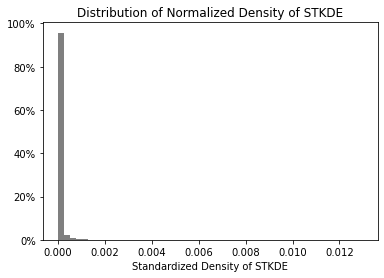

In [30]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
## Normalize the data
norm1 = arr / np.linalg.norm(arr)
num_bins = 50
n, bins, patches = plt.hist(norm1, num_bins, weights=np.ones(len(norm1)) / len(norm1), facecolor='black', alpha=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of Normalized Density of STKDE')
plt.xlabel('Standardized Density of STKDE')

plt.show()

Create a chart for Cumulative Distribution of Normalized Density of STKDE

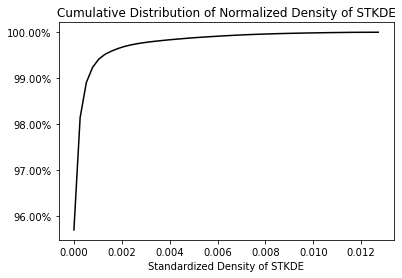

In [31]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
num_bins = 50
values, base = np.histogram(norm1, num_bins)
## find the cumulative distribution
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/max(cumulative), c='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Cumulative Distribution of Normalized Density of STKDE')
plt.xlabel('Standardized Density of STKDE')
plt.show()

<a id='vis'></a>
## Visualization
This section includes 3-D visulization of the STKDE result for COVID-19 death case distribution. The Calcuation is conducted with Wolfram Mathmatica, and the code used for this calculation are store in ./wolfram_mathmatica/visulization.nb.

Five clusters are detected with STKDE, which are centered around 1: New York City, 2: Chicago/Detroit/Indianapolis, 3: Houston, 4: Miami/Tampa, and 5: LA/San Diego. The figure provide above view.

<img src="img/above.png">

side view

<img src="img/side.png">